# Importing Modules

In [50]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import seaborn as sns
import boto3
from sagemaker import get_execution_role

Set picture format

In [2]:
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

sns.set_context('poster')
sns.set(style="ticks")
get_ipython().run_line_magic('matplotlib', 'inline')

# read data from S3 bucket and show data

In [36]:
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.

role = get_execution_role()
bucket='ids721-project'
train_key = 'startup_train.csv'
test_key = 'startup_test_new.csv'
train = 's3://{}/{}'.format(bucket, train_key)
test =  's3://{}/{}'.format(bucket, test_key)


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [38]:
orgin_traindata= pd.read_csv(train)
orgin_testdata = pd.read_csv(test)
orgin_testdata = orgin_testdata.drop(['ID'],axis=1)
orgin_traindata=pd.concat([orgin_traindata,orgin_testdata],axis=0)

In [39]:
orgin_traindata.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,founded_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,state_code.1,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1/1/2007,4/1/2009,1/1/2010,2.2493,3.0027,4.6685,6.7041,3,3,375000,3,CA,1,0,0,0,0,music,0,0,0,0,0,0,0,0,0,1,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1/1/2000,2/14/2005,12/28/2009,5.1260,9.9973,7.0055,7.0055,9,4,40100000,1,CA,1,0,0,0,0,enterprise,0,0,0,1,0,0,0,0,0,0,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,3/18/2009,3/30/2010,3/30/2010,1.0329,1.0329,1.4575,2.2055,5,1,2600000,2,CA,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1/1/2002,2/17/2005,4/25/2007,3.1315,5.3151,6.0027,6.0027,5,3,40000000,1,CA,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,8/1/2010,8/1/2010,4/1/2012,0.0000,1.6685,0.0384,0.0384,2,2,1300000,1,CA,1,0,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,c:65806,1,1,0,0,0,0,1.0000,1,closed


In [40]:
orgin_testdata.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,founded_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,state_code.1,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,701,CA,37.404788,-121.940842,95134,c:40147,San Jose,San Jose CA 95134,C2 Microsystems,1/1/2004,10/12/2009,10/12/2009,5.7836,5.7836,2.0027,2.0027,1,1,10000000,1,CA,1,0,0,0,0,hardware,0,0,0,0,0,0,0,0,0,1,c:40147,1,0,0,0,0,0,3.0,1,NaN
1,978,CA,37.421022,-122.137741,94301,c:62269,Palo Alto,NaN,GoPollGo,1/1/2011,7/27/2011,7/27/2011,0.5671,0.5671,0.5671,2.3534,5,1,425000,3,CA,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,c:62269,0,1,0,0,0,0,2.0,1,NaN
2,201,CA,35.966068,-115.118671,95066,c:16273,Scotts Valley,NaN,Multigig,1/1/2003,5/12/2008,12/22/2010,5.3644,7.9781,5.2521,5.2521,5,3,37891054,1,CA,1,0,0,0,0,semiconductor,0,0,0,0,0,0,0,0,0,1,c:16273,1,0,0,1,1,0,3.0,1,NaN
3,665,CA,32.833501,-117.261620,92037,c:38196,La Jolla,La Jolla CA 92037,Ortiva Wireless,1/1/2004,2/1/2005,10/4/2011,1.0877,7.7616,6.8849,6.8849,9,5,40000000,1,CA,1,0,0,0,0,mobile,0,0,1,0,0,0,0,0,0,0,c:38196,1,0,1,1,1,0,4.0,1,NaN
4,897,CA,34.048857,-118.251343,90245,c:5411,El Segundo,NaN,Sometrics,9/1/2007,5/14/2008,10/16/2009,0.7014,2.1260,2.4027,4.0548,10,3,5550000,4,CA,1,0,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,c:5411,0,0,1,1,0,0,3.0,1,NaN


# Do data engineering 

In [41]:
def checkCategories(categories_name,table,significant_number):
    a=table.groupby(categories_name,as_index=False)["id"].count()
    a=a.sort_values(by='id',ascending=False)
    a=a.rename(columns={'id':'count_overall'})
    b=orgin_traindata.groupby ([categories_name,'status'],as_index=False).agg ({"id":"count"})
    b.sort_values(by='id',ascending=False)
    b=b[b["status"]=="acquired"].sort_values(by='id',ascending=False)
    b=b.rename(columns={'id':'count_aquired'})
    merged=pd.merge(a,b,how='left')
    merged['percentile']=merged.apply(lambda x:x['count_aquired']/x['count_overall'],axis=1)
    merged.fillna(0,inplace = True)
    
    categories_drop=merged[((merged["percentile"]<0.750000) & (merged["percentile"]>0.250000))|(merged["count_overall"]<significant_number)][categories_name].values
    print(len(categories_drop))
    print(merged.sort_values(by='percentile',ascending=False))
    return categories_drop

In [42]:
#process category data
traindata = orgin_traindata.drop(["is_CA","is_NY","is_MA","is_TX","is_otherstate","is_software","is_web","is_mobile","is_enterprise","is_advertising","is_gamesvideo","is_ecommerce","is_biotech","is_consulting","is_othercategory"],axis=1)
category_code  =  checkCategories("category_code",traindata,20)
traindata['category_code']=traindata['category_code'].apply(lambda x:'others' if x in category_code else x)
zip_code =  checkCategories("zip_code",traindata,20)
state_code = checkCategories("state_code",traindata,20)
traindata['state_code']=traindata['state_code'].apply(lambda x:'others' if x in state_code else x)
traindata['zip_code']=traindata['zip_code'].apply(lambda x:'others' if x in zip_code else x)
city = checkCategories("city",traindata, 20)
traindata['city']=traindata['city'].apply(lambda x:'others' if x in city else x)
traindata=pd.get_dummies(traindata,columns=['state_code','city','zip_code','category_code'])


35
       category_code  count_overall    status  count_aquired  percentile
34            sports              1  acquired            1.0    1.000000
32    transportation              2  acquired            2.0    1.000000
24             music              6  acquired            6.0    1.000000
28            health              3  acquired            3.0    1.000000
33       hospitality              1  acquired            1.0    1.000000
19              news              8  acquired            6.0    0.750000
26         education              4  acquired            3.0    0.750000
21            travel              8  acquired            6.0    0.750000
3         enterprise             73  acquired           54.0    0.739726
13          security             19  acquired           14.0    0.736842
23       photo_video              7  acquired            5.0    0.714286
14         analytics             19  acquired           13.0    0.684211
7    network_hosting             34  acquired   

In [43]:
#drop irrelevant colume
traindata = traindata.drop(["id","Unnamed: 6","founded_at","first_funding_at","last_funding_at","name","founded_at","last_funding_at","state_code.1","object_id"],axis=1)

In [44]:
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


<class 'pandas.core.frame.DataFrame'>
Int64Index: 305 entries, 4 to 847
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age_first_funding_year    305 non-null    float64
 1   age_last_funding_year     305 non-null    float64
 2   latitude                  305 non-null    float64
 3   milestones                305 non-null    int64  
 4   avg_participants          305 non-null    float64
 5   longitude                 305 non-null    float64
 6   age_first_milestone_year  203 non-null    float64
 7   age_last_milestone_year   203 non-null    float64
 8   status                    305 non-null    object 
dtypes: float64(7), int64(1), object(1)
memory usage: 23.8+ KB


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/lib/histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


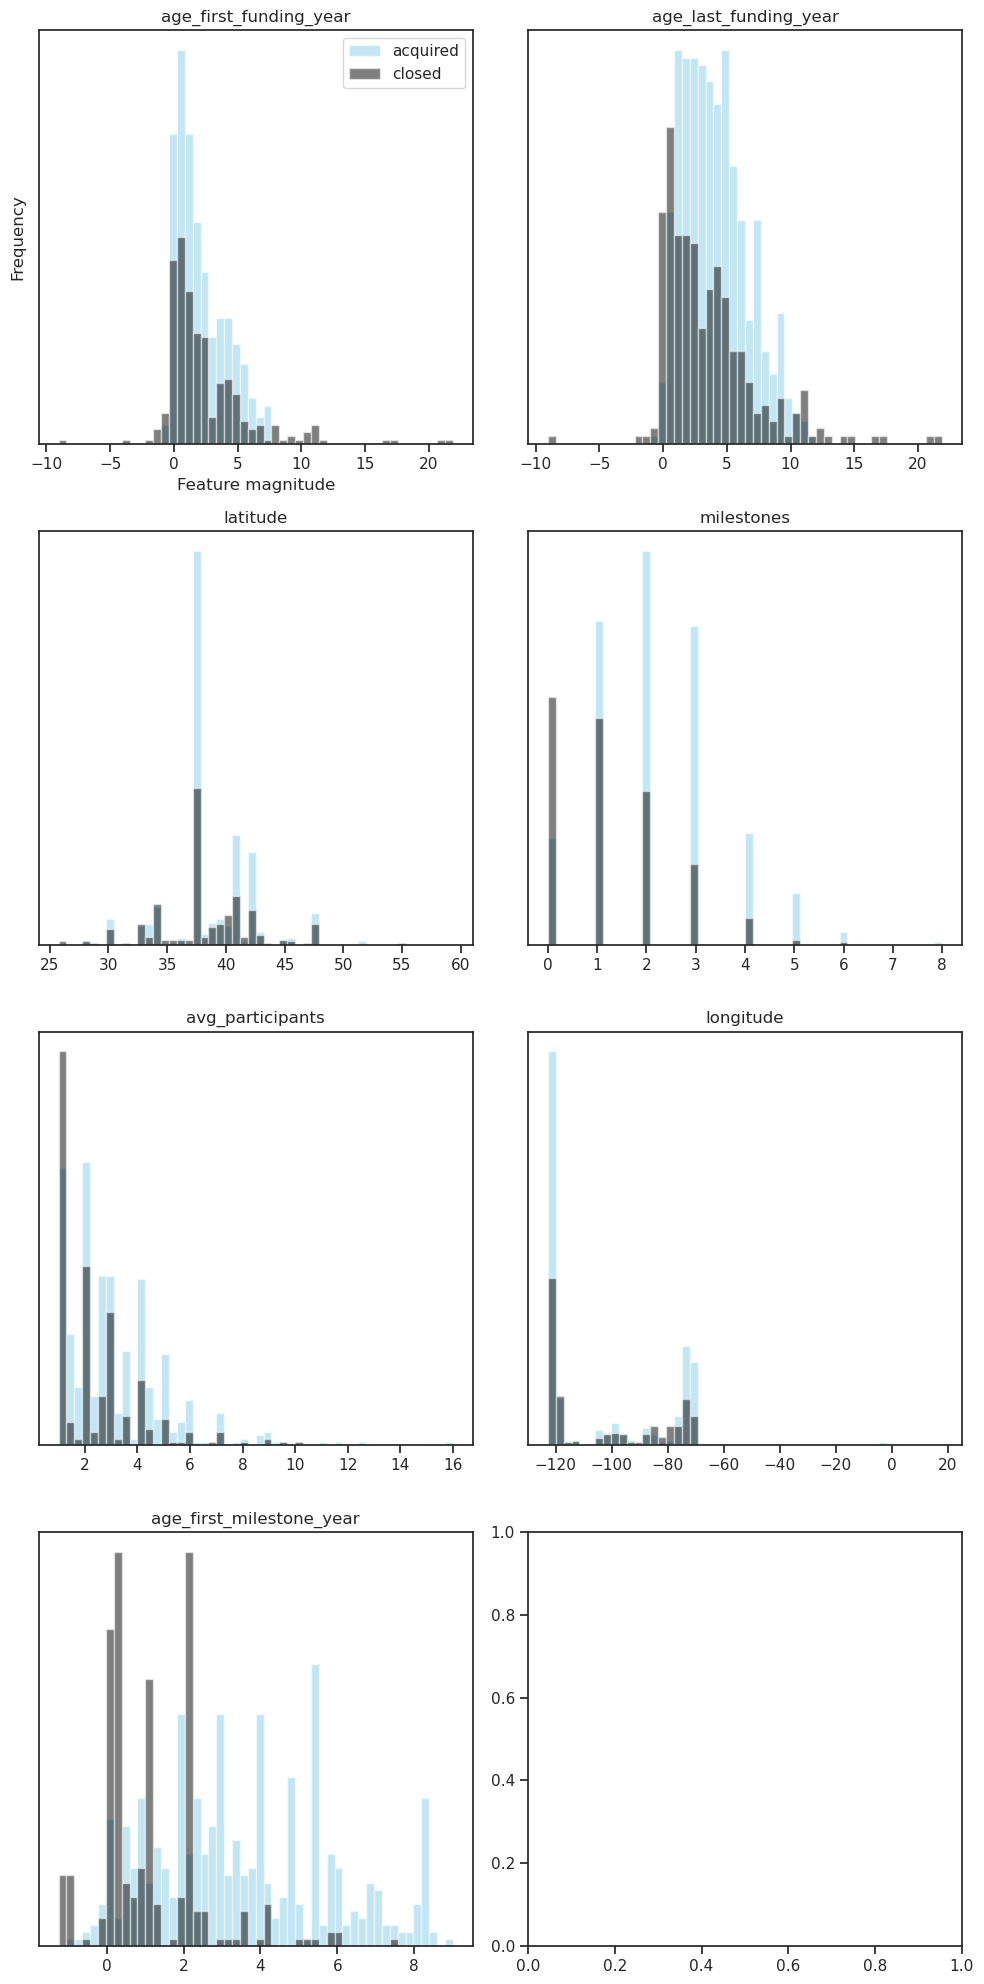

In [45]:
#check the quantity data 
#import mglearn
train=traindata.loc[:,["age_first_funding_year", "age_last_funding_year","latitude","milestones","avg_participants","longitude"  ,"age_first_milestone_year", "age_last_milestone_year",'status']]
success=train.loc[train['status']=='acquired',:]
failed=train.loc[train['status']=='closed',:]

data=train.values

failed.info()
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
ax = axes.ravel()
for i in range(7):
    _, bins = np.histogram(data[:, i], bins=50)
    ax[i].hist(success.values[:, i], bins=bins, color='skyblue', alpha=.5)
    ax[i].hist(failed.values[:, i], bins=bins, color='black', alpha=.5)
    ax[i].set_title(train.columns.to_list()[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["acquired", "closed"], loc="best")
fig.tight_layout()

In [46]:
#check na
missing_data = traindata.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data
pd.DataFrame({"# Missing": missing_data, "% Missing": round(missing_data / len(traindata) * 100, 2)})

,# Missing,% Missing
age_first_milestone_year,152,16.47
age_last_milestone_year,152,16.47
status,75,8.13


In [47]:
#deal with na
traindata['age_first_milestone_year'].fillna(traindata['age_first_milestone_year'].mean(), inplace = True)
traindata['age_last_milestone_year'].fillna(traindata['age_last_milestone_year'].mean(), inplace = True)

In [48]:
#map
traindata['status']=traindata['status'].map({'acquired':1,'closed':0})

# seperate train attribute and target and start machine learning

In [16]:
# Separate features and target variables
features = traindata.drop('status', axis = 1)
# features=features.loc[:,['latitude','longitude',"relationships","is_top500","milestones","funding_rounds","funding_total_usd"]]
target = traindata['status']
# Train test split
X_train = features.iloc[:848,:]
Y_train = target[:848]
X_test = features.iloc[848:,:]

/tmp/ipykernel_7882/1219033294.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Y_train = target[:848]


In [17]:
# compare method ： select from model
from sklearn.feature_selection import SelectFromModel
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")
select.fit(X_train, Y_train)
X_train_l1 = select.transform(X_train)
X_test_l1 = select.transform(X_test)

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=23, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/decomposition/_base.py:125: RuntimeWarning: divide by zero encountered in true_divide
  X_transformed /= np.sqrt(self.explained_variance_)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/decomposition/_base.py:125: RuntimeWarning: invalid value encountered in true_divide
  X_transformed /= np.sqrt(self.explained_variance_)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/decomposition/_base.py:125: RuntimeWarning: invalid value encountered in true_divide
  X_transformed /= np.sqrt(self.explained_variance_)


In [20]:
# GridSearchCV for RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(n_jobs = -1, random_state = 10)
params = {
    'n_estimators': [5, 50, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, params, cv = 5, n_jobs = -1) #GridSearchCV，它存在的意义就是自动调参，只要把参数输进去，就能给出最优化的结果和参数。
cv.fit(X_train_l1, Y_train)
pd.DataFrame(cv.cv_results_).sort_values('mean_test_score', ascending = False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,0.883998,0.108716,0.054528,0.004783,None,250,"{'max_depth': None, 'n_estimators': 250}",0.800000,0.817647,0.782353,0.822485,0.822485,0.808994,0.015681,1
14,0.935560,0.012623,0.053659,0.002349,32,250,"{'max_depth': 32, 'n_estimators': 250}",0.800000,0.817647,0.782353,0.822485,0.822485,0.808994,0.015681,1
11,0.924603,0.017751,0.055697,0.005584,16,250,"{'max_depth': 16, 'n_estimators': 250}",0.794118,0.817647,0.788235,0.822485,0.816568,0.807811,0.013853,3
8,0.854279,0.006502,0.056225,0.003177,8,250,"{'max_depth': 8, 'n_estimators': 250}",0.800000,0.794118,0.788235,0.810651,0.834320,0.805465,0.016217,4
5,0.740667,0.025769,0.052735,0.007842,4,250,"{'max_depth': 4, 'n_estimators': 250}",0.794118,0.811765,0.782353,0.810651,0.828402,0.805458,0.015847,5


In [21]:
# final prediction
rf = RandomForestClassifier(n_estimators = 32, max_depth = 50, n_jobs = -1, random_state = 42)
# Fit model
rf_model = rf.fit(X_train, Y_train)
# Predict 
Y_pred = rf_model.predict(X_test)

In [22]:
# write back to check list for kaggle checker
ID=np.arange(1,76,1).reshape(-1,1)
test_result=np.hstack([ID, Y_pred.reshape(-1,1)])
test_result=pd.DataFrame(test_result,columns=['ID','status'])
test_result['ID']=test_result['ID'].apply(lambda x:int(x))
test_result['status']=test_result['status'].map({1:"acquired",0:"closed"})
test_result.to_csv('test4.csv',index=0)
test_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      75 non-null     int64 
 1   status  75 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.3+ KB


# use Sagemaker

# Step 1: Prepare the data

In [68]:
X_data = traindata.drop('status', axis = 1)
Y_data = traindata['status']

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X_data, Y_data, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sk.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

In [69]:
import os
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

In [70]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost')
prefix = 'startup-xgboost-deploy-hl'

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [71]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

In [72]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [73]:
pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [74]:

val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

# Step 2: Train the ML model

In [75]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2023-03-22-19-10-45-509


2023-03-22 19:10:45 Starting - Starting the training job......
2023-03-22 19:11:19 Starting - Preparing the instances for training......
2023-03-22 19:12:44 Downloading - Downloading input data...
2023-03-22 19:13:14 Training - Downloading the training image......
2023-03-22 19:14:10 Uploading - Uploading generated training modelArguments: train
[2023-03-22:19:14:01:INFO] Running standalone xgboost training.
[2023-03-22:19:14:01:INFO] File size need to be processed in the node: 0.06mb. Available memory size in the node: 8595.75mb
[2023-03-22:19:14:01:INFO] Determined delimiter of CSV input is ','
[19:14:01] S3DistributionType set as FullyReplicated
[19:14:01] 414x23 matrix with 9522 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-03-22:19:14:01:INFO] Determined delimiter of CSV input is ','
[19:14:01] S3DistributionType set as FullyReplicated
[19:14:01] 204x23 matrix with 4692 entries loaded from /opt/ml/input/data/validation?format=csv&label_co

# Step 3: Deploy the model

In [ ]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2023-03-22-19-15-00-997
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-03-22-19-15-00-997
INFO:sagemaker:Creating endpoint with name xgboost-2023-03-22-19-15-00-997


------

In [ ]:
test_data_array = X_test.values #load the data into an array
#xgb_predictor.content_type = 'text/csv' # set the data type for an inference
xgb_predictor.serializer = csv_serializer # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

# Step 4: Evaluate model performance

In [ ]:
cm = pd.crosstab(index=Y_test, columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "Success", "failure"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("succe", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("failure", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))

# Step 5: Clean up

In [ ]:
xgb_predictor.delete_endpoint()
# xgb_predictor.delete_endpoint(delete_endpoint_config=True)